In [1]:
import numpy as np
import os
from skimage import io
from scipy.misc import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pickle
seed = 42
np.random.seed(seed)

In [2]:
file_loc = 'lfw-deepfunneled//'

ctr = 0
idx = 0
MIN_SAMPLES = 20
name = [None]
img = []
label = []
for root, dirs, files in os.walk(file_loc):
    for file in files:
        with open(os.path.join(root, file), "r") as img_data:
            name.append(img_data.name)
        idx+=1
    if(idx>MIN_SAMPLES):
        [(img.append(imread(x)),label.append(ctr)) for x in name if x != None]
        ctr+=1
    name = [None]
    idx=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


In [3]:
nb_classes = max(label)+1
print(len(label))

2923


In [4]:
unique, counts = np.unique(label, return_counts=True)

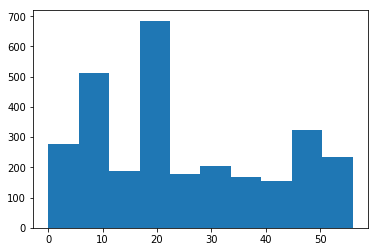

In [5]:
plt.hist(label)
plt.show()

In [6]:
len(unique), len(img)

(57, 2923)

In [7]:
l = np.asarray((unique, counts)).T
l[:10]

array([[  0, 121],
       [  1,  25],
       [  2,  22],
       [  3,  26],
       [  4,  29],
       [  5,  53],
       [  6, 109],
       [  7,  23],
       [  8, 236],
       [  9,  21]])

In [8]:
def fn(cls):
    return list(set(range(len(img))) - set(cls))

cls_gp = [None]*nb_classes
cls_gp_bar = [None]*nb_classes
cls_gp[0] = list(range(counts[0]))
cls_gp_bar[0] = fn(cls_gp[0])

for i in range(1,nb_classes):
    cls_gp[i] = list(range(counts[i-1], counts[i-1]+counts[i]))
    cls_gp_bar[i] = fn(cls_gp[i])

In [9]:
len(img)

2923

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(img),np.array(label), train_size=0.9, random_state = 20)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train) 
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, nb_classes)

(2630, 250, 250, 3) (293, 250, 250, 3) 57


In [12]:
print(y_train.shape)

(2630,)


In [13]:
with open('train_test_dt_1.pkl', 'wb') as handle:
    pickle.dump((X_train, X_test, y_train, y_test, nb_classes, img, label, unique, counts), handle)

In [14]:
with open('train_test_dt_1.pkl', 'rb') as handle:
    X_train, X_test, y_train, y_test, nb_classes, img, label, unique, counts = pickle.load(handle)

In [15]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [17]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, nb_classes)

(2630, 250, 250, 3) (2630, 57) (293, 250, 250, 3) (293, 57) 57


In [18]:
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
from keras.applications import VGG16

Using TensorFlow backend.


In [20]:
from keras.layers import Flatten, Dense, Lambda
from keras.models import Model
from keras.engine.topology import Input


input_tensor = Input(shape=img[0].shape)
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
for layer in base_model.layers:
    layer.trainable=False
'''
x = vgg_conv.layers[1](inp)
for layer in vgg_conv.layers[1:]:
    x = layer(x)
'''
top_model = models.Sequential()

# Add new layers
top_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer'))
'''
x = Flatten()(x)
x = Dense(1024, activation='relu', name='dense_emb_layer')
x = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')

model = Model(inputs=[inp], outputs=x)
'''
model = Model(input= base_model.input, output= top_model(base_model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [21]:
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=img[0].shape)
in_p = Input(shape=img[0].shape)
in_n = Input(shape=img[0].shape)

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.5, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
train_model = Model([in_a, in_p, in_n], triplet_loss_layer)

In [22]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128)          17926080    input_3[0][0]                    
                                                                 input_4[0][0]                    
          

In [23]:
def find_cls_gp(set_img, set_label):
    set_unique, set_counts = np.unique(set_label, return_counts=True)
    def fn(cls):
        return list(set(range(len(set_img))) - set(cls))
    
    set_cls_gp = [None]*nb_classes
    set_cls_gp_bar = [None]*nb_classes
    set_cls_gp[0] = list(range(set_counts[0]))
    set_cls_gp_bar[0] = fn(set_cls_gp[0])

    for i in range(1,nb_classes):
        set_cls_gp[i] = list(range(set_counts[i-1], set_counts[i-1]+set_counts[i]))
        set_cls_gp_bar[i] = fn(set_cls_gp[i])
        
    return (set_cls_gp, set_cls_gp_bar)

In [24]:
def triplet_batch(set_img, set_label, batch_size = 32, seed = 42):
    '''
    sd = [(i,i,j) for i in range(nb_classes) for j in range(nb_classes) if (j!=i)]
    ls = np.random.choice(np.arange(len(sd)), batch_size)
    idc = [sd[x] for x in ls]
    '''
    assert len(set_img) == len(set_label)
    set_cls_gp, set_cls_gp_bar = find_cls_gp(set_img, set_label)
    #print('Max values set_grp {}, set_grp_bar {}, len {}'.format(max(set_cls_gp), max(set_cls_gp_bar), len(set_img)))
    while True:
        anc_in, pos_in, neg_in = [],[],[]
        seed+=1
        np.random.seed(seed)
        lbl_iter = np.random.choice(range(nb_classes), batch_size, replace=True)
        for t in lbl_iter:
            q = set_cls_gp[t]
            q_bar = set_cls_gp_bar[t]
            
            if (len(q) == 0):
                raise Exception('Train set does not have images of label {}'.format(t))

            anc,pos = np.random.choice(q,2,replace=False)
            neg = int(np.random.choice(q_bar,1)[0])
            
            anc_in.append(anc)
            pos_in.append(pos)
            neg_in.append(neg)
        anc_imgs = np.array([set_img[x] for x in anc_in])
        pos_imgs = np.array([set_img[x] for x in pos_in])
        neg_imgs = np.array([set_img[x] for x in neg_in])
        yield ([anc_imgs,pos_imgs,neg_imgs], None)

In [25]:
train_triplet_batch = triplet_batch(X_train,y_train)
val_triplet_batch = triplet_batch(X_test,y_test)

In [26]:
print(train_triplet_batch)

<generator object triplet_batch at 0x7f7e40163518>


In [27]:
sa = next(train_triplet_batch)[0]
sa[0].shape, sa[1].shape, sa[2].shape

((32, 250, 250, 3), (32, 250, 250, 3), (32, 250, 250, 3))

In [28]:
batch_size = 32
train_steps = (len(X_train)//batch_size)
val_steps = (len(X_test)//batch_size)
train_steps, val_steps

(82, 9)

In [29]:
train_model.compile(loss=None, optimizer='adam')
hist = train_model.fit_generator(train_triplet_batch, 
                          steps_per_epoch=train_steps,
                          #steps_per_epoch=2,
                          epochs=10,
                          validation_data=train_triplet_batch,
                          validation_steps=val_steps)
                          #validation_steps=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """Entry point for launching an IPython kernel.


Epoch 1/10
82/82 [==============================] - 1050s 13s/step - loss: 8.0679 - val_loss: 3.2019
Epoch 2/10
82/82 [==============================] - 1043s 13s/step - loss: 2.9172 - val_loss: 2.3186
Epoch 3/10
82/82 [==============================] - 1043s 13s/step - loss: 2.1662 - val_loss: 2.3564
Epoch 4/10
82/82 [==============================] - 1042s 13s/step - loss: 1.7999 - val_loss: 1.7636
Epoch 5/10
82/82 [==============================] - 1041s 13s/step - loss: 1.4835 - val_loss: 1.3427
Epoch 6/10
82/82 [==============================] - 1045s 13s/step - loss: 1.4725 - val_loss: 0.8854
Epoch 7/10
82/82 [==============================] - 1044s 13s/step - loss: 1.2826 - val_loss: 1.0461
Epoch 8/10
82/82 [==============================] - 1043s 13s/step - loss: 1.2935 - val_loss: 0.9232
Epoch 9/10
82/82 [==============================] - 1044s 13s/step - loss: 1.0720 - val_loss: 0.9399
Epoch 10/10
82/82 [==============================] - 1043s 13s/step - loss: 1.0807 - val_lo

dict_keys(['val_loss', 'loss'])


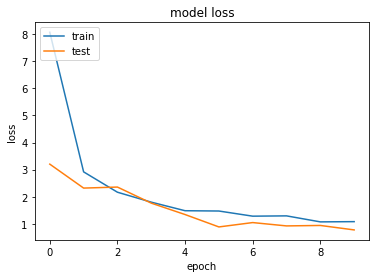

In [30]:
history = hist
# list all data in history
print(history.history.keys())
'''
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
hist = train_model.fit_generator(train_triplet_batch, 
                          steps_per_epoch=train_steps,
                          epochs=10,
                          validation_data=train_triplet_batch,
                          validation_steps=val_steps)

Epoch 1/10
82/82 [==============================] - 1044s 13s/step - loss: 0.8930 - val_loss: 0.7626
Epoch 2/10
82/82 [==============================] - 1123s 14s/step - loss: 1.0897 - val_loss: 1.0334
Epoch 3/10
82/82 [==============================] - 1184s 14s/step - loss: 1.1389 - val_loss: 0.8034
Epoch 4/10
82/82 [==============================] - 1059s 13s/step - loss: 0.9278 - val_loss: 0.9471
Epoch 5/10
82/82 [==============================] - 1087s 13s/step - loss: 1.0433 - val_loss: 1.0065
Epoch 6/10
82/82 [==============================] - 1056s 13s/step - loss: 0.7671 - val_loss: 0.9030
Epoch 7/10
82/82 [==============================] - 1056s 13s/step - loss: 0.9072 - val_loss: 1.2553
Epoch 8/10
82/82 [==============================] - 1056s 13s/step - loss: 0.8690 - val_loss: 0.8512
Epoch 9/10
82/82 [==============================] - 1056s 13s/step - loss: 0.9312 - val_loss: 1.0551
Epoch 10/10
82/82 [==============================] - 1056s 13s/step - loss: 0.9320 - val_lo

dict_keys(['val_loss', 'loss'])


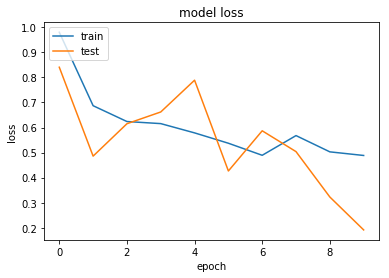

In [172]:
history = hist
# list all data in history
print(history.history.keys())
'''
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.save('triplet_model_2.h5')
train_model.save('triplet_train_model_2.h5')

In [38]:
embedded = np.zeros((len(img), 128))

In [39]:
for i in range(len(img)):
    tr_img = (img[i] / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = model.predict(np.expand_dims(tr_img, axis=0))[0]

In [40]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

In [41]:
def emb(x, y):
    print(distance(embedded[x], embedded[y]))
print(emb(2, 3))
print(emb(2, 327))

0.1701521198528336
None
0.8277562602678239
None


In [153]:
l = model.predict(np.expand_dims(X_test[0], axis=0))[0]
l.shape

(1024,)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Numerical encoding of identities
y = np.array(label)

train_idx = [x for x in range(len(img)) if x % 2 != 0]
test_idx = [x for x in range(len(img)) if x % 2 == 0]
print(train_idx[:5])

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

[1, 3, 5, 7, 9]


NameError: name 'accuracy_score' is not defined

In [15]:
from tensorflow.python.keras._impl.keras import backend as K


In [17]:
net_data = np.load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()
print(net_data.keys())
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])


In [18]:
from keras.engine.topology import Layer
import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'th':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'tf':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            #outputs = K.concatenate(outputs,axis = 1)
            outputs = K.concatenate(outputs)
            #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
            #outputs = K.permute_dimensions(outputs,(3,1,0,2))
            #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

Using TensorFlow backend.


In [19]:
import numpy as np
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense
from keras.engine.topology import Input
from keras.models import Model

batch_size = 32
num_channels = 3
num_classes = 10
img_x, img_y, img_z = img[0].shape

img_input = Input(batch_shape=(batch_size, None, None, num_channels))
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same', name='conv1')(img_input)
x = local_resp_norm(name='lrn_1')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x)
x = Conv2D(32, (3, 3), activation='relu', name='conv4')(x)
x = SpatialPyramidPooling([1, 2, 4])(x)
predictions = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=img_input, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
#model.fit_generator()

# train on 64x64x3 images
model.fit(s[0][:32], s[1][:32])
# train on 32x32x3 images
#model.fit(np.random.rand(batch_size, num_channels, 32, 32), np.zeros((batch_size, num_classes)))

Epoch 1/1
32/32 [==============================] - 38s 1s/step - loss: 8.6585 - acc: 0.0000e+00


In [13]:
import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical

In [14]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [17]:
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import *
#from keras.engine.topology import Layer
#import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):
        
        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = tf.shape(x)

        num_rows = input_shape[1]
        num_cols = input_shape[2]

        row_length = [tf.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [ttf.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        for pool_num, num_pool_regions in enumerate(self.pool_list):
            for jy in range(num_pool_regions):
                for ix in range(num_pool_regions):
                    x1 = ix * col_length[pool_num]
                    x2 = ix * col_length[pool_num] + col_length[pool_num]
                    y1 = jy * row_length[pool_num]
                    y2 = jy * row_length[pool_num] + row_length[pool_num]

                    x1 = tf.cast(tf.round(x1), 'int32')
                    x2 = tf.cast(tf.round(x2), 'int32')
                    y1 = tf.cast(tf.round(y1), 'int32')
                    y2 = tf.cast(tf.round(y2), 'int32')

                    new_shape = [input_shape[0], y2 - y1,
                                 x2 - x1, input_shape[3]]

                    x_crop = x[:, y1:y2, x1:x2, :]
                    xm = tf.reshape(x_crop, new_shape)
                    pooled_val = tf.max(xm, axis=(1, 2))
                    outputs.append(pooled_val)

        return tf.concatenate(outputs)

In [30]:
net_data = np.load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()
print(net_data.keys())
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])


In [31]:
zeros((1, 227,227,3)).astype(float32).shape[1:]

(227, 227, 3)

In [32]:
random.sample(range(30),5)

TypeError: random_sample() takes at most 1 positional argument (2 given)

In [ ]:
def batch_gen(batch_size=32):
    maxlen = Y_train.shape[0]
    random.sample(, )

In [ ]:
################################################################################
#Michael Guerzhoy and Davi Frossard, 2016
#AlexNet implementation in TensorFlow, with weights
#Details: 
#http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
#
#With code from https://github.com/ethereon/caffe-tensorflow
#Model from  https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet
#Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow
#
#
################################################################################

from numpy import *
import os
#from pylab import *
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random


import tensorflow as tf

#from caffe_classes import class_names

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]
batch_size = 64

'''

################################################################################
#Read Image, and change to BGR


im1 = (imread("laska.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]

im2 = (imread("poodle.png")[:,:,:3]).astype(float32)
im2[:, :, 0], im2[:, :, 2] = im2[:, :, 2], im2[:, :, 0]


################################################################################

# (self.feed('data')
#         .conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
#         .lrn(2, 2e-05, 0.75, name='norm1')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
#         .conv(5, 5, 256, 1, 1, group=2, name='conv2')
#         .lrn(2, 2e-05, 0.75, name='norm2')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
#         .conv(3, 3, 384, 1, 1, name='conv3')
#         .conv(3, 3, 384, 1, 1, group=2, name='conv4')
#         .conv(3, 3, 256, 1, 1, group=2, name='conv5')
#         .fc(4096, name='fc6')
#         .fc(4096, name='fc7')
#         .fc(1000, relu=False, name='fc8')
#         .softmax(name='prob'))
'''

def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(kernel, group, 3)  #tf.split(3, group, kernel) 
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])



x = tf.placeholder(tf.float32, (None,) + xdim)


#conv1
#conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4

conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2


conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1


conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2


conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2


conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

#fc8
#fc(1000, relu=False, name='fc
fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)


#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)
init = tf.global_variables_initializer()

xdim = X_train[0].shape[1:]
images_placeholder = tf.placeholder(tf.float32, (None,) + xdim)
labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size))

t = time.time()

with tf.Session() as sess:
    sess.run(init)
    output = sess.run(prob, feed_dict = {x:[im1,im2]})

#Output:


for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    '''
    for i in range(5):
        print(class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]])
    '''
print(time.time()-t)

In [31]:
"""This is an TensorFLow implementation of AlexNet by Alex Krizhevsky at all.

Paper:
(http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Explanation can be found in my blog post:
https://kratzert.github.io/2017/02/24/finetuning-alexnet-with-tensorflow.html

This script enables finetuning AlexNet on any given Dataset with any number of
classes. The structure of this script is strongly inspired by the fast.ai
Deep Learning class by Jeremy Howard and Rachel Thomas, especially their vgg16
finetuning script:
Link:
- https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16.py


The pretrained weights can be downloaded here and should be placed in the same
folder as this file:
- http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

@author: Frederik Kratzert (contact: f.kratzert(at)gmail.com)
"""

import tensorflow as tf
import numpy as np


class AlexNet(object):
    """Implementation of the AlexNet."""

    def __init__(self, x, keep_prob, num_classes, skip_layer,
                 weights_path='DEFAULT'):
        """Create the graph of the AlexNet model.

        Args:
            x: Placeholder for the input tensor.
            keep_prob: Dropout probability.
            num_classes: Number of classes in the dataset.
            skip_layer: List of names of the layer, that get trained from
                scratch
            weights_path: Complete path to the pretrained weight file, if it
                isn't in the same folder as this code
        """
        # Parse input arguments into class variables
        self.X = x
        self.NUM_CLASSES = num_classes
        self.KEEP_PROB = keep_prob
        self.SKIP_LAYER = skip_layer

        if weights_path == 'DEFAULT':
            self.WEIGHTS_PATH = 'bvlc_alexnet.npy'
        else:
            self.WEIGHTS_PATH = weights_path

        # Call the create function to build the computational graph of AlexNet
        self.create()

    def create(self):
        """Create the network graph."""
        # 1st Layer: Conv (w ReLu) -> Lrn -> Pool
        conv1 = conv(self.X, 11, 11, 96, 4, 4, padding='VALID', name='conv1')
        norm1 = lrn(conv1, 2, 1e-05, 0.75, name='norm1')
        pool1 = max_pool(norm1, 3, 3, 2, 2, padding='VALID', name='pool1')
        
        # 2nd Layer: Conv (w ReLu)  -> Lrn -> Pool with 2 groups
        conv2 = conv(pool1, 5, 5, 256, 1, 1, groups=2, name='conv2')
        norm2 = lrn(conv2, 2, 1e-05, 0.75, name='norm2')
        pool2 = max_pool(norm2, 3, 3, 2, 2, padding='VALID', name='pool2')
        
        # 3rd Layer: Conv (w ReLu)
        conv3 = conv(pool2, 3, 3, 384, 1, 1, name='conv3')

        # 4th Layer: Conv (w ReLu) splitted into two groups
        conv4 = conv(conv3, 3, 3, 384, 1, 1, groups=2, name='conv4')

        # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
        conv5 = conv(conv4, 3, 3, 256, 1, 1, groups=2, name='conv5')
        pool5 = max_pool(conv5, 3, 3, 2, 2, padding='VALID', name='pool5')

        # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
        flattened = tf.reshape(pool5, [-1, 6*6*256])
        fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
        dropout6 = dropout(fc6, self.KEEP_PROB)

        # 7th Layer: FC (w ReLu) -> Dropout
        fc7 = fc(dropout6, 4096, 4096, name='fc7')
        dropout7 = dropout(fc7, self.KEEP_PROB)

        # 8th Layer: FC and return unscaled activations
        self.fc8 = fc(dropout7, 4096, self.NUM_CLASSES, relu=False, name='fc8')

    def load_initial_weights(self, session):
        """Load weights from file into network.

        As the weights from http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
        come as a dict of lists (e.g. weights['conv1'] is a list) and not as
        dict of dicts (e.g. weights['conv1'] is a dict with keys 'weights' &
        'biases') we need a special load function
        """
        # Load the weights into memory
        weights_dict = np.load(self.WEIGHTS_PATH, encoding='bytes').item()

        # Loop over all layer names stored in the weights dict
        for op_name in weights_dict:

            # Check if layer should be trained from scratch
            if op_name not in self.SKIP_LAYER:

                with tf.variable_scope(op_name, reuse=True):

                    # Assign weights/biases to their corresponding tf variable
                    for data in weights_dict[op_name]:

                        # Biases
                        if len(data.shape) == 1:
                            var = tf.get_variable('biases', trainable=False)
                            session.run(var.assign(data))

                        # Weights
                        else:
                            var = tf.get_variable('weights', trainable=False)
                            session.run(var.assign(data))


def conv(x, filter_height, filter_width, num_filters, stride_y, stride_x, name,
         padding='SAME', groups=1):
    """Create a convolution layer.

    Adapted from: https://github.com/ethereon/caffe-tensorflow
    """
    # Get number of input channels
    input_channels = int(x.get_shape()[-1])

    # Create lambda function for the convolution
    convolve = lambda i, k: tf.nn.conv2d(i, k,
                                         strides=[1, stride_y, stride_x, 1],
                                         padding=padding)

    with tf.variable_scope(name) as scope:
        # Create tf variables for the weights and biases of the conv layer
        weights = tf.get_variable('weights', shape=[filter_height,
                                                    filter_width,
                                                    input_channels/groups,
                                                    num_filters])
        biases = tf.get_variable('biases', shape=[num_filters])

    if groups == 1:
        conv = convolve(x, weights)

    # In the cases of multiple groups, split inputs & weights and
    else:
        # Split input and weights and convolve them separately
        input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
        weight_groups = tf.split(axis=3, num_or_size_splits=groups,
                                 value=weights)
        output_groups = [convolve(i, k) for i, k in zip(input_groups, weight_groups)]

        # Concat the convolved output together again
        conv = tf.concat(axis=3, values=output_groups)

    # Add biases
    bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))

    # Apply relu function
    relu = tf.nn.relu(bias, name=scope.name)

    return relu


def fc(x, num_in, num_out, name, relu=True):
    """Create a fully connected layer."""
    with tf.variable_scope(name) as scope:

        # Create tf variables for the weights and biases
        weights = tf.get_variable('weights', shape=[num_in, num_out],
                                  trainable=True)
        biases = tf.get_variable('biases', [num_out], trainable=True)

        # Matrix multiply weights and inputs and add bias
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)

    if relu:
        # Apply ReLu non linearity
        relu = tf.nn.relu(act)
        return relu
    else:
        return act


def max_pool(x, filter_height, filter_width, stride_y, stride_x, name,
             padding='SAME'):
    """Create a max pooling layer."""
    return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1],
                          strides=[1, stride_y, stride_x, 1],
                          padding=padding, name=name)


def lrn(x, radius, alpha, beta, name, bias=1.0):
    """Create a local response normalization layer."""
    return tf.nn.local_response_normalization(x, depth_radius=radius,
                                              alpha=alpha, beta=beta,
                                              bias=bias, name=name)


def dropout(x, keep_prob):
    """Create a dropout layer."""
    return tf.nn.dropout(x, keep_prob)

In [32]:
#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 1000, [])

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

In [ ]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')